# Evaluation of the sensitivity of the statistical test
The objective of this notebook is to assess the sensitivity of the statistical test detecting a significant change of signatures between the clones. To achieve that, for each possible number of clones between 2 and 6, 30 alternative $\pi$ matrices (the mixture of signatures for each clone) were drawn such that their maximal cosine distance between each clone's profile is thouroughly sampled between 0 and 0.5, with enough points below 0.1, where sensitivity changes dramatically with the maximum distance. For each case, the number of mutations varies among $\{100, 300, 1000\}$, the diploid proportion of the genome $\{0.1, 0.5, 0.9\}$, and the sequencing depth $\{30, 100, 500\}$.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import collections
from pathlib import Path

pd.options.display.max_columns = 200
os.chdir('..')
output_path = '20200515_paper_figures/sensitivity_eval'
Path(output_path).mkdir(parents=True, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
clonesig_res = pd.read_csv('20200512_eval_clonesig_power_statistical_test_sensitivity.csv', sep='\t')
clonesig_res = clonesig_res[(clonesig_res.method=="clonesig")]


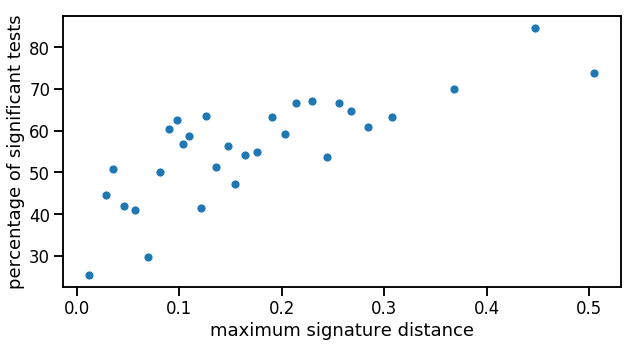

In [4]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )

clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
clonesig_resb['max_dist_y'] = np.round(clonesig_resb['max_dist_y'], 3)
subdata=pd.DataFrame(clonesig_resb.groupby('max_dist_y').sig.sum()/clonesig_resb.groupby('max_dist_y').sig.count()) * 100
subdata = subdata.assign(max_dist=subdata.index)
plt.figure(figsize=(10,5))
ax=sns.scatterplot(x='max_dist', y='sig', data=subdata)
ax.set_xlabel('maximum signature distance')
ax.set_ylabel('percentage of significant tests')
plt.savefig('{}/overall_test_sensitivity.pdf'.format(output_path),
            bbox_inches='tight')


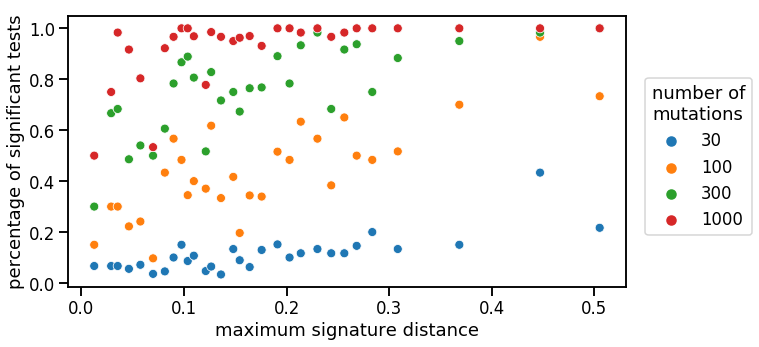

In [5]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )
clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
subdata=pd.DataFrame(clonesig_resb.groupby(['max_dist_y', 'nb_mut']).sig.sum()/clonesig_resb.groupby(['max_dist_y', 'nb_mut']).sig.count())
subdata = subdata.assign(max_dist=subdata.index.get_level_values(0))
subdata = subdata.assign(nb_mut=pd.Categorical(subdata.index.get_level_values(1)))
plt.figure(figsize=(10,5))
ax=sns.scatterplot(x='max_dist', y='sig', data=subdata, hue='nb_mut')
ax.set_xlabel('maximum signature distance')
ax.set_ylabel('percentage of significant tests')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=2,
          bbox_to_anchor=(1.02, 0.8), title='number of\nmutations')
plt.savefig('{}/overall_test_sensitivity_mutations.pdf'.format(output_path),
            bbox_inches='tight')



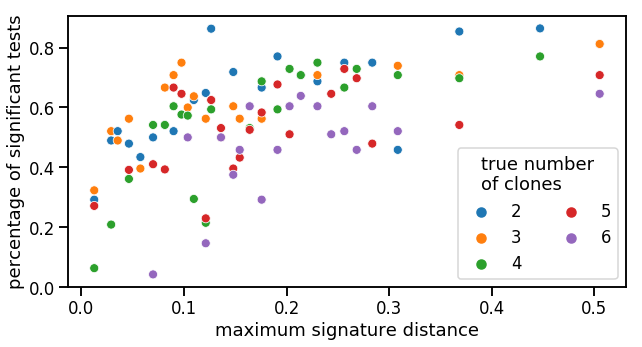

In [6]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )
clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
clonesig_resb = clonesig_resb.assign(nb_clones=clonesig_resb.nb_phi)
subdata=pd.DataFrame(clonesig_resb.groupby(['max_dist_y', 'nb_clones']).sig.sum()/clonesig_resb.groupby(['max_dist_y', 'nb_clones']).sig.count())
subdata = subdata.assign(max_dist=subdata.index.get_level_values(0))
subdata = subdata.assign(nb_clones=pd.Categorical(subdata.index.get_level_values(1)))
plt.figure(figsize=(10,5))
ax=sns.scatterplot(x='max_dist', y='sig', data=subdata, hue='nb_clones')
ax.set_xlabel('maximum signature distance')
ax.set_ylabel('percentage of significant tests')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=0, ncol=2,
          title='true number\nof clones')
plt.savefig('{}/overall_test_sensitivity_clones.pdf'.format(output_path),
            bbox_inches='tight')


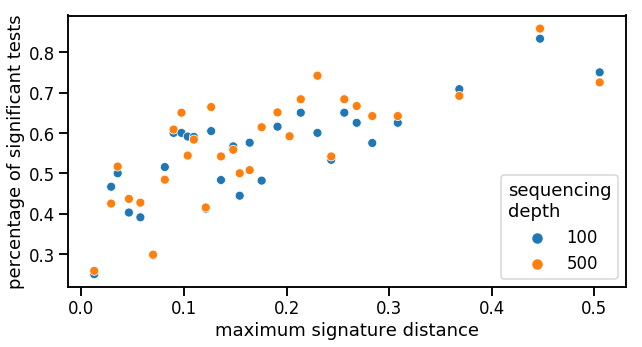

In [7]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )
clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
subdata=pd.DataFrame(clonesig_resb.groupby(['max_dist_y', 'depth']).sig.sum()/clonesig_resb.groupby(['max_dist_y', 'depth']).sig.count())
subdata = subdata.assign(max_dist=subdata.index.get_level_values(0))
subdata = subdata.assign(depth=pd.Categorical(subdata.index.get_level_values(1)))
plt.figure(figsize=(10,5))
ax=sns.scatterplot(x='max_dist', y='sig', data=subdata, hue='depth')
ax.set_xlabel('maximum signature distance')
ax.set_ylabel('percentage of significant tests')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=0, ncol=1,
          title='sequencing\ndepth')
plt.savefig('{}/overall_test_sensitivity_depth.pdf'.format(output_path),
            bbox_inches='tight')


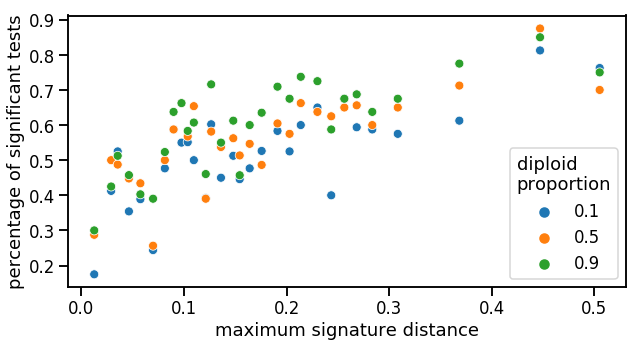

In [8]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )
clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
subdata=pd.DataFrame(clonesig_resb.groupby(['max_dist_y', 'perc_diploid']).sig.sum()/clonesig_resb.groupby(['max_dist_y', 'perc_diploid']).sig.count())
subdata = subdata.assign(max_dist=subdata.index.get_level_values(0))
subdata = subdata.assign(perc_diploid=pd.Categorical(subdata.index.get_level_values(1)))
plt.figure(figsize=(10,5))
ax=sns.scatterplot(x='max_dist', y='sig', data=subdata, hue='perc_diploid')
ax.set_xlabel('maximum signature distance')
ax.set_ylabel('percentage of significant tests')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=0, ncol=1,
          title='diploid\nproportion')
plt.savefig('{}/overall_test_sensitivity_dip.pdf'.format(output_path),
            bbox_inches='tight')


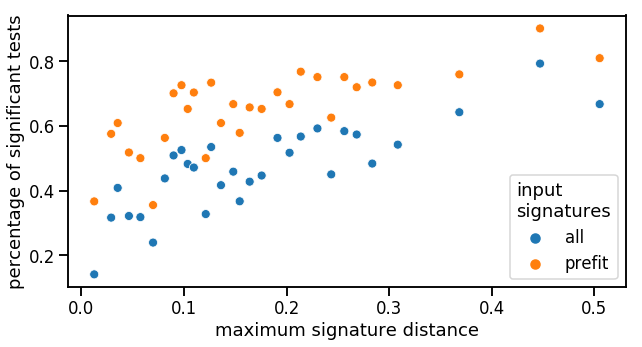

In [9]:
sns.set_context('talk')
clonesig_res = clonesig_res.assign(sig=clonesig_res.pval<0.05)
clonesig_res['max_dist_quantized'] = pd.qcut(clonesig_res['max_dist'], 30, labels=False )
clonesig_resb = pd.merge(clonesig_res, clonesig_res.groupby('max_dist_quantized').max_dist.mean().to_frame(), left_on='max_dist_quantized', right_index=True)
subdata=pd.DataFrame(clonesig_resb.groupby(['max_dist_y', 'setting']).sig.sum()/clonesig_resb.groupby(['max_dist_y', 'setting']).sig.count())
subdata = subdata.assign(max_dist=subdata.index.get_level_values(0))
subdata = subdata.assign(setting=pd.Categorical(subdata.index.get_level_values(1)))
plt.figure(figsize=(10,5))
ax=sns.scatterplot(x='max_dist', y='sig', data=subdata, hue='setting')
ax.set_xlabel('maximum signature distance')
ax.set_ylabel('percentage of significant tests')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=0, ncol=1,
          title='input\nsignatures')
plt.savefig('{}/overall_test_sensitivity_setting.pdf'.format(output_path),
            bbox_inches='tight')
